In [1]:
# install
# pip install novosparc

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [3]:
import cv2 as cv
from skimage import io, color
import torch
from torch.nn import functional as F
import json

In [4]:
%cd /lustre03/project/6075067/calcium/2021/CeLEry

/lustre03/project/6075067/calcium/2021/CeLEry


In [5]:
from data.MouseBrain.MP1_SVG import d_g

In [6]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel
cel.__version__

'1.1.2'

In [7]:
import tangram as tg

In [8]:
tg.__version__

'1.0.0'

##  1. Data Preperation
### Load MouseBarin Data Section 1: Spatial Transcriptomic Data


In [9]:
dataSection1full = sc.read("data/MouseBrain/MP1_sudo.h5ad")
genename = dataSection1full.var['genename']

In [10]:
# Get the gene list from the pre-screening
genelistlist = [d_g[i] for i in  range(len(d_g))]  # transform dictionary to a list of lists
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]


In [11]:
#Read in hitology image
ImageSec1=io.imread("data/MouseBrain/V1_Mouse_Brain_Sagittal_Posterior_image.tif")
ImageSec1sub = ImageSec1[3000:7000,6200:10500,:]
# spc.printimage (ImageSec1sub, "../output/CeLEry/imageselect")


In [12]:
imgray = cv.cvtColor(ImageSec1sub, cv.COLOR_BGR2GRAY)
imgray2 = imgray.copy()
imgray2[imgray2<160] = 0
imgray2[imgray2>160] = 255

## Take the subset of dataSection1
xcords = dataSection1full.obs["x"].to_numpy()
ycords = dataSection1full.obs["y"].to_numpy()

Section1Sub = dataSection1full[(xcords>=3000) & (xcords<7000) & (ycords>=6200) & (ycords<10500), genelistindex]
Section1Sub.obs = Section1Sub.obs/50
Section1Sub.obs = Section1Sub.obs.astype(int)
Section1Sub.obs["inner"] = 0

## Quality Control

for i in range(Section1Sub.obs.shape[0]):
    xi = Section1Sub.obs["x"][i]
    yi = Section1Sub.obs["y"][i]
    subarea = np.mean(imgray2[(xi*50-3000):(xi*50+50-3000), (yi*50-6200):(yi*50+50-6200)])
    if subarea<140 or xi*50>6000:
         Section1Sub.obs["inner"].iloc[i] = 1
    if yi*50>10200 or xi*50<1000:
         Section1Sub.obs["inner"].iloc[i] = 0

Section1Sub = Section1Sub[Section1Sub.obs["inner"] == 1]


Load the index of holdoff. Making sure all methods are comparable.

In [13]:
cel.get_zscore(Section1Sub)

# random.seed(2021)
# torch.manual_seed(2021)
# np.random.seed(2021)

# index10 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.1))
# index30 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.3))
# index50 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.5))

# np.save("../output/CeLEry/index10.npy", index10)
# np.save("../output/CeLEry/index30.npy", index30)
# np.save("../output/CeLEry/index50.npy", index50)

index10 = np.load("output/CeLEry/index10.npy")
index30 = np.load("output/CeLEry/index30.npy")
index50 = np.load("output/CeLEry/index50.npy")


In [14]:
# split the data into training and testing data

# 10% hold off
Section1train10 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index10)),]
Section1test10 = Section1Sub[list(set(index10)),]

# 30% hold off
Section1train30 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index30)),]
Section1test30 = Section1Sub[list(set(index30)),]

# 50% hold off
Section1train50 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index50)),]
Section1test50 = Section1Sub[list(set(index50)),]


In [15]:
def Tangram_run(holdoff, datatrain, datatest):
    random.seed(2021)
    torch.manual_seed(2021)
    np.random.seed(2021)
    ## Running novosparc
    tg.pp_adatas(datatest, datatrain, genes=None)
    location_pred = tg.map_cells_to_space(datatest, datatrain)
    # location_pred = sc.read("output/CeLEry/Tangram/map_{holdoff}.h5ad".format(holdoff = holdoff))
    
    ## For each cell  of the "scRNA", find the predicted location on Spatial map
    S1_xmax = datatrain.obs['x'].max() + 1
    S1_xmin = datatrain.obs['x'].min() - 1
    S1_ymax = datatrain.obs['y'].max() + 1
    S1_ymin = datatrain.obs['y'].min() - 1
    #
    S2_xmax = datatest.obs['x'].max() + 1
    S2_xmin = datatest.obs['x'].min() - 1
    S2_ymax = datatest.obs['y'].max() + 1
    S2_ymin = datatest.obs['y'].min() - 1
    ## Normalize the coordinates of both Sections
    spx = (datatrain.obs.iloc[:,0] - S1_xmin) / (S1_xmax - S1_xmin)
    spy = (datatrain.obs.iloc[:,1] - S1_ymin) / (S1_ymax - S1_ymin)
    truex = (datatest.obs.iloc[:,0] - S2_xmin) / (S2_xmax - S2_xmin)
    truey = (datatest.obs.iloc[:,1] - S2_ymin) / (S2_ymax - S2_ymin)
    #
    total_loss_tg = []
    coords_predict = np.zeros((datatest.obs.shape[0],4))

    for i in range(location_pred.shape[0]):
        bestindex = np.argmax(location_pred.X[i,:])
        truth = torch.FloatTensor([truex[i],truey[i]])
        pred = torch.FloatTensor([spx[bestindex],spy[bestindex]])
        coords_predict[i,0:2] = pred
        coords_predict[i,2:4] = truth
        loss = F.mse_loss(truth,pred)
        total_loss_tg.append(loss)
    #
    losstotal_itemize = [x.item() for x in total_loss_tg]
    losstotal = sum(losstotal_itemize)
    print('Loss for enhancement data only:{:.4f}'.format(float(losstotal)))

    np.savetxt("output/CeLEry/Tangram/location_{holdoff}_predict.csv".format(holdoff = holdoff), coords_predict)
    #
    cel.RelocationPlot(coords_predict, datatest.obs[["x","y"]], filename = "output/CeLEry/Tangram/location_{holdoff}".format(holdoff = holdoff))
    SSIM_result =  cel.get_SSIM(coords_predict, referadata = datatest, trainAnn = datatrain, referlocation = datatest.obs[["x","y"]], genelist = range(datatest.X.shape[1]))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][0,:,:,0]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][0,:,:]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_anchor_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][1,:,:,0]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][1,:,:]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_anchor_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][2,:,:,0]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_3".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][2,:,:]), filename = "output/CeLEry/Tangram/Tangram_{holdoff}_SSIM_anchor_3".format(holdoff = holdoff))
    np.save("output/CeLEry/Tangram/Tangram_{holdoff}_SSIM.npy".format(holdoff = holdoff), np.array(SSIM_result[0]))
    np.save("output/CeLEry/Tangram/Tangram_{holdoff}_cor.npy".format(holdoff = holdoff), np.array(SSIM_result[3]))
    np.save("output/CeLEry/Tangram/Tangram_{holdoff}_MSE.npy".format(holdoff = holdoff), np.array(SSIM_result[4]))
    del SSIM_result
    #
    # result_tg = sc.AnnData(X= np.expand_dims(np.array(losstotal_itemize),  axis = 1))
    # result_tg.obs = datatest.obs[["x","y"]]
    # cel.getGeneImg(result_tg, emptypixel = -0.1)
    # cel.plotGeneImg(result_tg.GeneImg[0,:,:],filename = "output/CeLEry/novosparc/imgDNNnovosparc_{holdoff}".format(holdoff = holdoff), range = (-0.1,0.6))
    #
    #
    results = {"MSE":str(round(losstotal,4))}
    with open("output/CeLEry/Tangram/Tangram_results_{holdoff}.txt".format(holdoff = holdoff), 'w') as file:
        file.write(json.dumps(results))
    return losstotal


INFO:root:358 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:358 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 358 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.007, KL reg: 3042.717
Score: 0.280, KL reg: 2581.433
Score: 0.386, KL reg: 2579.665
Score: 0.429, KL reg: 2579.078
Score: 0.446, KL reg: 2578.808
Score: 0.450, KL reg: 2578.669
Score: 0.453, KL reg: 2578.592
Score: 0.455, KL reg: 2578.545
Score: 0.458, KL reg: 2578.514
Score: 0.460, KL reg: 2578.492


INFO:root:Saving results..


Loss for enhancement data only:29.2983


100%|██████████| 358/358 [00:04<00:00, 72.49it/s]


29.2982932407931

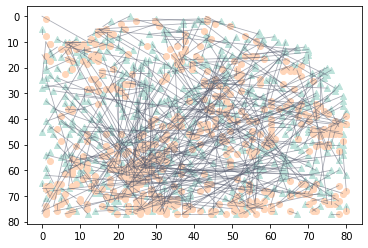

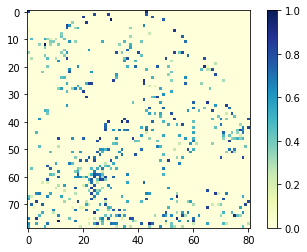

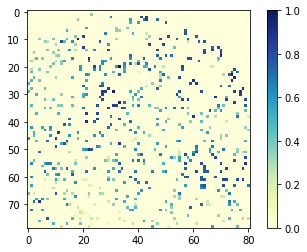

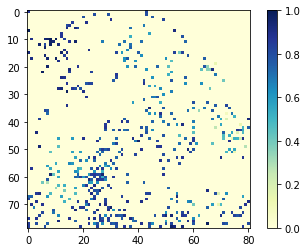

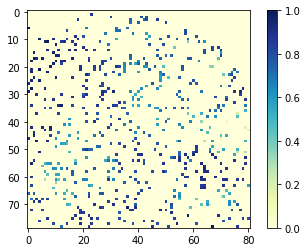

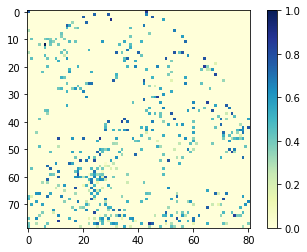

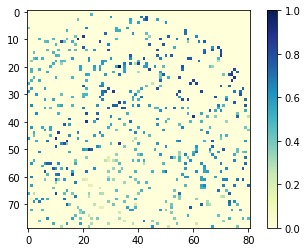

In [16]:
Tangram_run(holdoff = 10, datatrain = Section1train10, datatest = Section1test10)

INFO:root:358 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:358 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 358 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.008, KL reg: 246.494
Score: 0.469, KL reg: 193.150
Score: 0.513, KL reg: 192.944
Score: 0.520, KL reg: 192.890
Score: 0.524, KL reg: 192.866
Score: 0.527, KL reg: 192.854
Score: 0.529, KL reg: 192.846
Score: 0.530, KL reg: 192.841
Score: 0.531, KL reg: 192.838
Score: 0.532, KL reg: 192.836


INFO:root:Saving results..


Loss for enhancement data only:133.5699


100%|██████████| 358/358 [00:14<00:00, 25.30it/s]


133.56988750102028

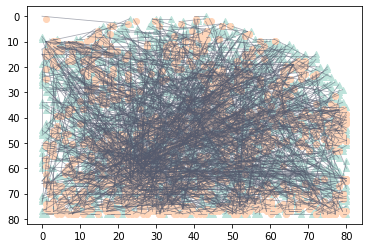

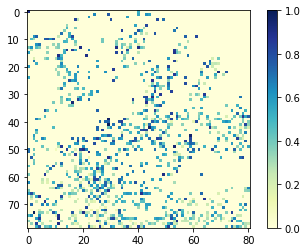

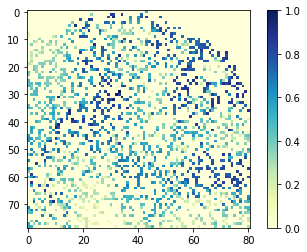

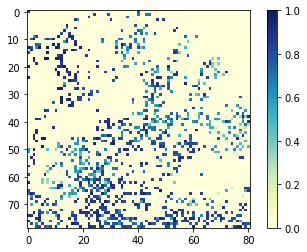

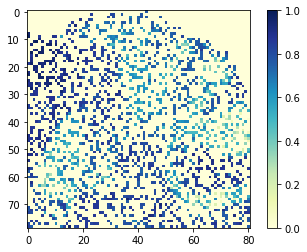

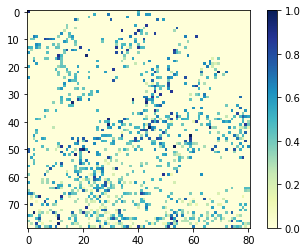

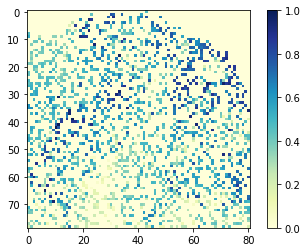

In [17]:
Tangram_run(holdoff = 30, datatrain = Section1train30, datatest = Section1test30)

INFO:root:358 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:358 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 358 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.004, KL reg: 533.219
Score: 0.482, KL reg: 430.064
Score: 0.529, KL reg: 429.652
Score: 0.533, KL reg: 429.538
Score: 0.537, KL reg: 429.491
Score: 0.539, KL reg: 429.466
Score: 0.541, KL reg: 429.452
Score: 0.543, KL reg: 429.442
Score: 0.544, KL reg: 429.436
Score: 0.545, KL reg: 429.431


INFO:root:Saving results..


Loss for enhancement data only:271.8859


100%|██████████| 358/358 [00:22<00:00, 15.69it/s]


271.88591837544664

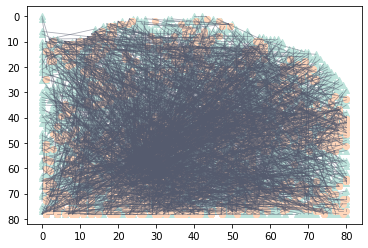

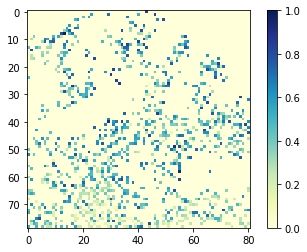

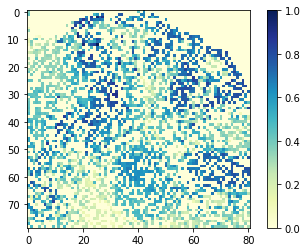

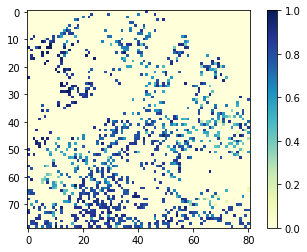

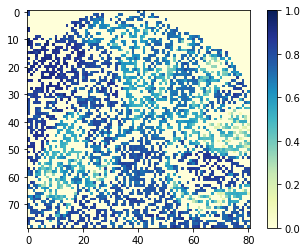

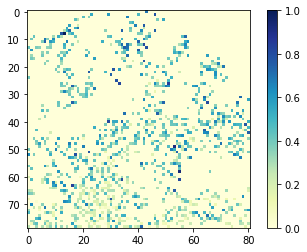

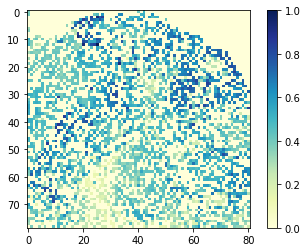

In [18]:
Tangram_run(holdoff = 50, datatrain = Section1train50, datatest = Section1test50)